# Problem Statement

Build an optimal model that can help us to identify bot traffic(Not-human traffic) and human traffic (HT).

# Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [0]:
# For processing and maths
import numpy as np
import pandas as pd
import re
import requests
import pickle

In [3]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 2)-Loading datasets 

In [4]:
df_bol =pd.read_csv('clickdata.csv')
df_bol.shape

(59782, 8)

In [5]:
df_bol.columns

Index(['epoch_ms', 'session_id', 'country_by_ip_address',
       'region_by_ip_address', 'url_without_parameters',
       'referrer_without_parameters', 'visitor_recognition_type',
       'ua_agent_class'],
      dtype='object')

In [6]:
df_bol.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,NaN,ANONYMOUS,Robot
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,NaN,ANONYMOUS,Robot
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,NaN,ANONYMOUS,Robot
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,NaN,ANONYMOUS,Robot Mobile


In [7]:
df_bol.tail()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
59777,1520287193332,6a98ec825aa0ccdc2aefb0d02f291cde,NL,NH,https://www.bol.com/nl/p/gladskin-rosacea-gel-...,NaN,RECOGNIZED,Browser
59778,1520287193930,70664825c07eeb2af81c77e7ef6f7493,US,CA,https://www.bol.com/nl/p/homedecoration-toront...,NaN,ANONYMOUS,Robot
59779,1520287196302,99935d53a2f5d6e95adaecba3ec288e6,US,CA,https://www.bol.com/nl/l/witte-nike-sportshirt...,NaN,ANONYMOUS,Robot
59780,1520287197700,0bff91927029f6402eff065680b0d8d8,US,CA,https://www.bol.com/nl/l/gadgetbay-randapparat...,NaN,ANONYMOUS,Robot
59781,1520287199048,01201ebb918c64ea4dabdabdfbcbd1b0,NL,NaN,https://www.bol.com/nl/p/hp-z3700-draadloze-mu...,NaN,ANONYMOUS,Browser


# 3)-Data Exploring

### 3.1)- Checking data-type

In [8]:
# Checking all variables with their data-type
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(df_bol)
table_dtype

,Data Type
epoch_ms,int64
session_id,object
country_by_ip_address,object
region_by_ip_address,object
url_without_parameters,object
referrer_without_parameters,object
visitor_recognition_type,object
ua_agent_class,object


### 3.2)- Checking missing values

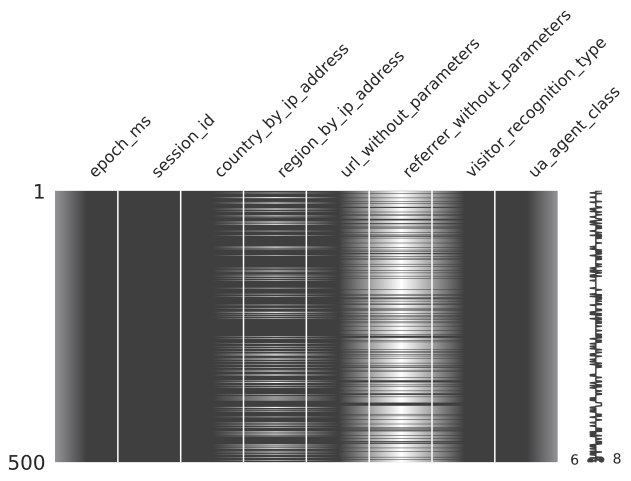

In [9]:
import missingno as msno

msno.matrix(df_bol.sample(500),
            figsize=(10, 5),
            width_ratios=(15, 1))

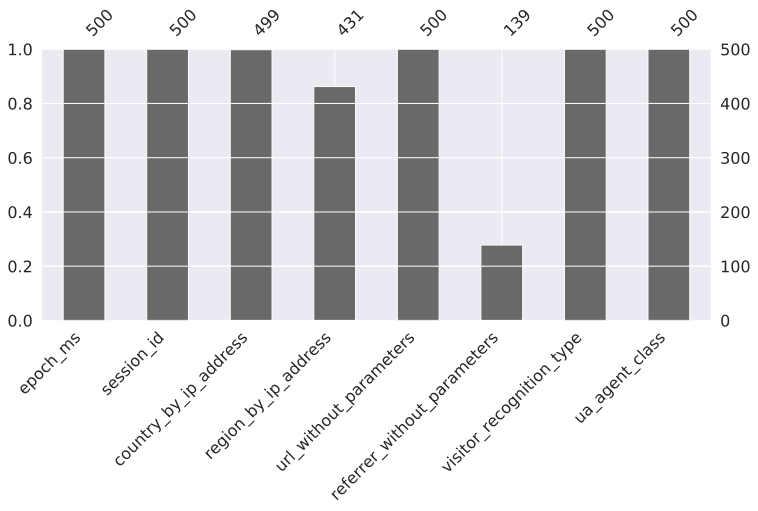

In [10]:
msno.bar(df_bol.sample(500),
            figsize=(12, 5),)

In [0]:
def summary_missing(dataset):
    n_miss = dataset.isnull().sum()
    n_obs = dataset.shape[0]
    n_miss_per = n_miss/n_obs*100
    n_miss_tbl = pd.concat([n_miss, n_miss_per], axis = 1).sort_values(1, ascending = False).round(1)
    n_miss_tbl = n_miss_tbl[n_miss_tbl[1] != 0]
    print('No. of fields: ', dataset.shape[0])
    print('No. of missing fields: ', n_miss_tbl.shape[0])
    n_miss_tbl = n_miss_tbl.rename(columns = {0:'No. of mising Value', 1:'%age of missing Value'})
    return n_miss_tbl

In [12]:
summary_missing(df_bol)

No. of fields:  59782
No. of missing fields:  3


,No. of mising Value,%age of missing Value
referrer_without_parameters,44778,74.9
region_by_ip_address,9896,16.6
country_by_ip_address,248,0.4


In [13]:
# checking each feature one by one starting with "referrer_without_parameters"

df_bol['referrer_without_parameters'].value_counts(dropna=False).head()

NaN                                                                         44778
https://www.bol.com/nl/s/algemeen/zoekresultaten/sc/media_all/index.html      693
https://www.bol.com/nl/chckout/checkout.html                                  396
https://www.bol.com/nl/m/voordeel/sale-solden/index.html                      215
https://www.bol.com/nl/s/algemeen/zoekresultaten/index.html                   173
Name: referrer_without_parameters, dtype: int64

NaN                                                                         44778

In [14]:
df_bol['country_by_ip_address'].value_counts(dropna=False).head(8)

NL     25673
US     22780
BE      7409
GB      1185
DE       616
FR       348
NaN      248
CN       236
Name: country_by_ip_address, dtype: int64

NaN      248

In [15]:
df_bol['region_by_ip_address'].value_counts(dropna=False).head()

CA     20662
NaN     9896
NH      4320
ZH      4160
VAN     2239
Name: region_by_ip_address, dtype: int64

NaN     9896

In [16]:
# use the 'isnull' Series method to filter the DataFrame rows. 
df_bol[df_bol.country_by_ip_address.isnull()].head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
44,1520280042769,ead0de034f327f2d65b1d3b6e1ccf3bd,NaN,NaN,https://www.bol.com/nl/p/stahlex-o10mm-140cm-a...,https://www.bol.com/nl/p/stahlex-o10mm-120cm-a...,ANONYMOUS,Browser
149,1520280121568,ead0de034f327f2d65b1d3b6e1ccf3bd,NaN,NaN,https://www.bol.com/nl/p/kettingslot-top-lock-...,NaN,ANONYMOUS,Browser
415,1520280294514,4a462ddfb4a61788864dd2db9d07a8df,NaN,NaN,https://www.bol.com/nl/l/mediaplayers/N/7114/,NaN,ANONYMOUS,Browser
961,1520280658423,465b8921f35bfb2dbbc4764c7fbe0572,NaN,NaN,https://www.bol.com/nl/l/alle-laptops/N/4770/,NaN,ANONYMOUS,Browser
987,1520280671831,1910b1489132245e4cd481260cc20362,NaN,NaN,https://www.bol.com/nl/l/kinderwagens/N/11274/,NaN,ANONYMOUS,Browser


**Filling missing value with "VARIOUS"**

We could either remove these missing values or we might fill them with an "entity". If it were numerical data then I would use impute option. As it is categorical data , we might add"various" or as training model suggests , we may also add ''.

In [0]:
df_bol['referrer_without_parameters'].fillna(value='VARIOUS', inplace=True)
df_bol['country_by_ip_address'].fillna(value='VARIOUS', inplace=True)
df_bol['region_by_ip_address'].fillna(value='VARIOUS', inplace=True)

In [18]:
summary_missing(df_bol)

No. of fields:  59782
No. of missing fields:  0


,No. of mising Value,%age of missing Value


Seems fine now

In [19]:
df_bol['referrer_without_parameters'].value_counts(dropna=False).head()

VARIOUS                                                                     44778
https://www.bol.com/nl/s/algemeen/zoekresultaten/sc/media_all/index.html      693
https://www.bol.com/nl/chckout/checkout.html                                  396
https://www.bol.com/nl/m/voordeel/sale-solden/index.html                      215
https://www.bol.com/nl/s/algemeen/zoekresultaten/index.html                   173
Name: referrer_without_parameters, dtype: int64

In [20]:
df_bol.shape

(59782, 8)

And we didnt lose any values

### 3.3)-checking duplicate values

In [21]:
print(df_bol.duplicated().sum())

0


### 3.4)-Sorting

In [22]:
df_bol.sort_values(by='visitor_recognition_type', ascending=False).head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
34496,1520280202558,da3b7564f35e8f28451ae65a9a9b66d1,NL,VARIOUS,https://www.bol.com/nl/b/ajax/index.html,https://www.bol.com/nl/b/baby-kinderkleding-jo...,RECOGNIZED,Browser
27702,1520281427095,b394bfb124a91cd9ebbedd4f14d5e4b0,BE,VAN,https://www.bol.com/nl/p/swampworld-dionaea-mu...,https://www.bol.com/nl/s/tuin/zoekresultaten/N...,RECOGNIZED,Browser
27721,1520281441407,e3d49b10074a12986d8868dd85835fb6,BE,VARIOUS,https://www.bol.com/nl/p/sistema-bake-it-versh...,https://www.bol.com/nl/s/algemeen/zoekresultat...,RECOGNIZED,Browser
12747,1520283062812,03988ce8b205597d44bc571d8a04162a,NL,GE,https://www.bol.com/nl/s/ajax/index.html,https://www.bol.com/nl/s/algemeen/zoekresultat...,RECOGNIZED,Browser
27716,1520281439193,01302b8ffd4ccc060e926d01171651c7,NL,VARIOUS,https://www.bol.com/nl/p/wereldbol-met-verlich...,VARIOUS,RECOGNIZED,Browser


In [23]:
df_bol.sort_values(by=['ua_agent_class', 'visitor_recognition_type'], ascending=[True, False]).head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
9,1520280013619,d3828e7e2638881c9b0f3bed0221f815,NL,ZH,https://www.bol.com/nl/t/elektronica/audio-hif...,VARIOUS,RECOGNIZED,Browser
19,1520280023995,6c3d7350dee7687fe8a550951ae2ad4a,NL,ZH,https://www.bol.com/nl/checkout/login.html,VARIOUS,RECOGNIZED,Browser
26,1520280033070,160fdd31c0a5ecfb6e27d0c9e99eceaa,NL,UT,https://www.bol.com/nl/p/ducksday-zomer-poncho...,https://www.bol.com/nl/s/algemeen/zoekresultat...,RECOGNIZED,Browser
37,1520280038110,13f24291bd85342a43c4afbdad7c6e9c,NL,GR,https://www.bol.com/nl/ra/boeken/gratis-verzen...,VARIOUS,RECOGNIZED,Browser
39,1520280039188,8e2499565ca2b5a8a1ece6080e09af5d,NL,NB,https://www.bol.com/nl/c/ajax/index.html,VARIOUS,RECOGNIZED,Browser


### groupby

In [24]:
df_bol.groupby(['ua_agent_class']).count()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type
ua_agent_class,,,,,,,
Browser,35509,35509,35509,35509,35509,35509,35509
Browser Webview,1800,1800,1800,1800,1800,1800,1800
Cloud Application,2,2,2,2,2,2,2
Hacker,1177,1177,1177,1177,1177,1177,1177
Mobile App,9,9,9,9,9,9,9
Robot,16026,16026,16026,16026,16026,16026,16026
Robot Mobile,5115,5115,5115,5115,5115,5115,5115
Special,144,144,144,144,144,144,144


In [25]:
df_bol.groupby(['ua_agent_class', 'visitor_recognition_type']).count()

epoch_ms  ...  referrer_without_parameters
ua_agent_class    visitor_recognition_type            ...                             
Browser           ANONYMOUS                    20390  ...                        20390
                  LOGGEDIN                      3076  ...                         3076
                  RECOGNIZED                   12043  ...                        12043
Browser Webview   ANONYMOUS                      849  ...                          849
                  LOGGEDIN                       406  ...                          406
                  RECOGNIZED                     545  ...                          545
Cloud Application ANONYMOUS                        2  ...                            2
Hacker            ANONYMOUS                     1176  ...                         1176
                  RECOGNIZED                       1  ...                            1
Mobile App        ANONYMOUS                        9  ...                            9
Robot             ANONYMOUS                    16026  ...                        16026
Robot Mobile      ANONYMOUS                     5115  ...                         5115
Special           ANONYMOUS                      144  ...                          144

[13 rows x 6 columns]

### 3.4)- Checking categorical features

In [26]:
# Checking unique categorical variables
df_bol.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

session_id                     30816
country_by_ip_address             66
region_by_ip_address             229
url_without_parameters         40696
referrer_without_parameters     6203
visitor_recognition_type           3
ua_agent_class                     8
dtype: int64

Our feature of interests are "ua_agent" being our independant feature, country_by_ip_address, region_by_ip_address and visitor_recognition_type.

In [27]:
# checking how many unique labels are in each feature
df_bol['visitor_recognition_type'].unique()

array(['ANONYMOUS', 'LOGGEDIN', 'RECOGNIZED'], dtype=object)

In [28]:
# how many times those labels classes occur
df_bol['visitor_recognition_type'].value_counts()

ANONYMOUS     43711
RECOGNIZED    12589
LOGGEDIN       3482
Name: visitor_recognition_type, dtype: int64

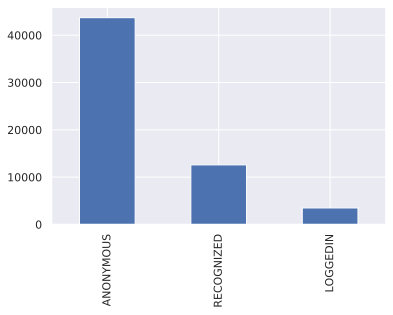

In [29]:
df_bol['visitor_recognition_type'].value_counts().plot.bar()

In [30]:
# Let's check other categorical variables such as country_by_ip_address

df_bol['country_by_ip_address'].unique()

array(['US', 'IT', 'NL', 'BE', 'VARIOUS', 'UA', 'FR', 'DE', 'PL', 'CN',
       'IE', 'RU', 'GB', 'AT', 'HU', 'JP', 'CA', 'PT', 'ES', 'CH', 'LT',
       'ID', 'IN', 'TR', 'IR', 'MY', 'NZ', 'AU', 'TH', 'BD', 'QA', 'CZ',
       'VN', 'MN', 'IL', 'FI', 'AM', 'DK', 'SR', 'GR', 'SE', 'LV', 'PK',
       'LU', 'MA', 'MD', 'BG', 'BR', 'HR', 'AR', 'AL', 'MK', 'GH', 'PY',
       'NO', 'RO', 'BO', 'ZA', 'SO', 'MC', 'MX', 'KR', 'DO', 'CW', 'SK',
       'KG'], dtype=object)

In [31]:
df_bol['country_by_ip_address'].value_counts()[:10]

NL         25673
US         22780
BE          7409
GB          1185
DE           616
FR           348
VARIOUS      248
CN           236
UA           192
RU           105
Name: country_by_ip_address, dtype: int64

In [32]:
df_bol['region_by_ip_address'].unique()

array(['CA', 'LI', 'NB', 'UT', 'ZH', 'VARIOUS', 'GE', 'DR', 'GR', 'FL',
       'BRU', 'VAN', 'NH', 'OV', 'SO', 'VLI', 'FR', 'OK', '30', 'VWV',
       'BW', 'MZ', 'BJ', 'ZE', 'VOV', 'VBR', 'L', 'VLA', 'BOL', 'WA', '7',
       '5', 'AZ', 'NY', 'PA', 'VA', 'BU', 'ENG', 'WHT', 'TN', '13', 'IL',
       'NV', '69', 'WNA', 'AL', 'IN', 'ON', 'WLG', 'NJ', 'MN', '11', 'ND',
       'AR', 'DA', 'RM', 'QC', 'SD', 'TOM', 'ZG', '05', 'JI', 'HE', 'AP',
       '59', 'CO', '08', '67', '03', '35', 'WBR', '14', 'AUK', 'NSW',
       '64', 'MOS', '23', 'MD', 'ZP', '10', 'IA', 'LU', 'LA', '29', 'KP',
       'HN', '1', 'NYK', 'TA', '18', 'BA', 'ER', '27', '07', '81', 'TX',
       'NW', 'IRK', 'CM', 'MI', '40', 'I', 'JK', 'SI', 'GA', '26', 'OR',
       'MS', '24', '71', 'WKO', '9', 'NC', 'VGG', 'AB', 'LK', 'MOW',
       'RIX', 'PB', 'M', 'ME', 'SL', 'KHE', 'OH', 'ID', 'CT', 'MO', 'MA',
       '6', 'NI', '12', 'GRE', 'BY', '92', 'CU', 'CAS', '20', 'A', 'GI',
       'SH', 'FI', 'SRY', 'BE', 'WI', 'NFK', 'ULY', '

In [33]:
df_bol['region_by_ip_address'].value_counts()[:10]

CA         20662
VARIOUS     9896
NH          4320
ZH          4160
VAN         2239
NB          2112
GE          1950
UT          1586
VOV         1333
OV          1055
Name: region_by_ip_address, dtype: int64

### 3.5)- Dependant Feature

In [34]:
df_bol['ua_agent_class'].unique()

array(['Robot', 'Browser', 'Robot Mobile', 'Browser Webview', 'Hacker',
       'Special', 'Mobile App', 'Cloud Application'], dtype=object)

In [35]:
df_bol.shape

(59782, 8)

I will choose to divide into only two categories according to our problem statement.Our categories are bot traffic coming  from search engines (NHT-search), other bot traffic (NHT-other) and human traffic (HT). 

- I will choose first a binary problem where we have only Non-human traffice and Human traffice.

- Second case will be for three classes where traffic coming  from search engines (NHT-search), other bot traffic (NHT-other) and human traffic (HT) will be considered

**I am not sure about what special is. So, I ll remove it from our category**

In [36]:
df_bol = df_bol[~df_bol['ua_agent_class'].isin(['Special'])]
df_bol.shape

(59638, 8)

In [37]:
df_bol.ua_agent_class.value_counts()

Browser              35509
Robot                16026
Robot Mobile          5115
Browser Webview       1800
Hacker                1177
Mobile App               9
Cloud Application        2
Name: ua_agent_class, dtype: int64

In [0]:
df_bol['labels'] = df_bol.ua_agent_class.map({'Robot':'NHT', 'Robot Mobile':'NHT','Browser':'HT', 'Browser Webview':'HT','Hacker':'HT','Mobile App':'HT','Cloud Application':'HT'})

In [39]:
df_bol.labels.value_counts()

HT     38497
NHT    21141
Name: labels, dtype: int64

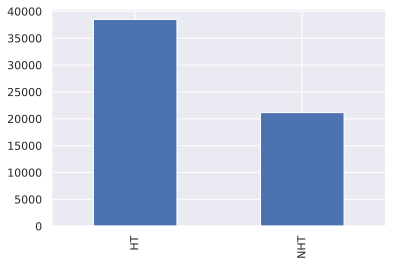

In [40]:
df_bol.labels.value_counts().plot(kind='bar')

### 3.6)-Checking relation with only one numerical variable

- epoch_ms: epoch in milliseconds

In [41]:
df_bol.describe()

,epoch_ms
count,5.963800e+04
mean,1.520283e+12
std,2.003379e+06
min,1.520280e+12
25%,1.520281e+12
50%,1.520283e+12
75%,1.520285e+12
max,1.520287e+12


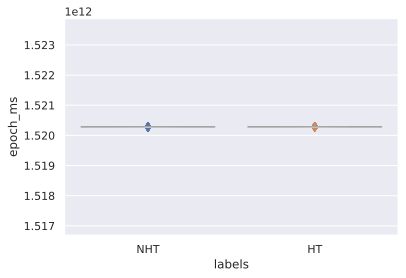

In [42]:
sns.boxenplot(x='labels',y='epoch_ms', data=df_bol)

### 3.7)-Dealing with epoch i.e Time 

In [0]:
from datetime import datetime

In [44]:
df_bol.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,labels
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,VARIOUS,ANONYMOUS,Robot,NHT
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,VARIOUS,ANONYMOUS,Robot,NHT
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser,HT
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,VARIOUS,ANONYMOUS,Robot,NHT
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,VARIOUS,ANONYMOUS,Robot Mobile,NHT


In [0]:
df_bol['date']=(pd.to_datetime(df_bol['epoch_ms'],unit='ms'))

In [46]:
df_bol.date[:5]

0   2018-03-05 20:00:01.034
1   2018-03-05 20:00:01.590
2   2018-03-05 20:00:02.397
3   2018-03-05 20:00:02.598
4   2018-03-05 20:00:04.428
Name: date, dtype: datetime64[ns]

In [47]:
df_bol.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,labels,date
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,VARIOUS,ANONYMOUS,Robot,NHT,2018-03-05 20:00:01.034
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,VARIOUS,ANONYMOUS,Robot,NHT,2018-03-05 20:00:01.590
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser,HT,2018-03-05 20:00:02.397
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,VARIOUS,ANONYMOUS,Robot,NHT,2018-03-05 20:00:02.598
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,VARIOUS,ANONYMOUS,Robot Mobile,NHT,2018-03-05 20:00:04.428


In [48]:
df_bol.dtypes

epoch_ms                                int64
session_id                             object
country_by_ip_address                  object
region_by_ip_address                   object
url_without_parameters                 object
referrer_without_parameters            object
visitor_recognition_type               object
ua_agent_class                         object
labels                                 object
date                           datetime64[ns]
dtype: object

We have converted eoch to datetime

- Still we have 2018-03-05 20:00:01.034 format. We better have a more useful format

In [0]:
df_bol['date'] = df_bol['date'].dt.date

In [50]:
df_bol.date[:5]

0    2018-03-05
1    2018-03-05
2    2018-03-05
3    2018-03-05
4    2018-03-05
Name: date, dtype: object

In [0]:
df_bol=df_bol.drop('epoch_ms', axis=1)

In [0]:
df_bol['date']=(pd.to_datetime(df_bol['date']))

In [56]:
df_bol.dtypes

session_id                             object
country_by_ip_address                  object
region_by_ip_address                   object
url_without_parameters                 object
referrer_without_parameters            object
visitor_recognition_type               object
ua_agent_class                         object
labels                                 object
date                           datetime64[ns]
dtype: object

In [0]:
df_bol['year']=df_bol.date.dt.year

### 3.8)- Visualize data

In [70]:
new_df=df_bol[['labels','year']]
new_df.head()

,labels,year
0,NHT,2018
1,NHT,2018
2,HT,2018
3,NHT,2018
4,NHT,2018


In [0]:
# making dataframe for count visualization
df_ct = (new_df.reset_index()
          .groupby(['year','labels'], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )

In [72]:
df_ct

,year,labels,ct
0,2018,HT,38497
1,2018,NHT,21141


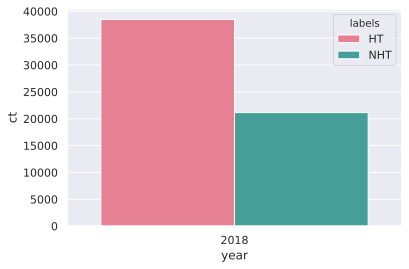

In [79]:
sns.barplot(x='year',y='ct',hue='labels', data=df_ct, palette='husl')

**Use month by month**

In [0]:
df_bol['month']=df_bol['date'].dt.month

In [83]:
df_month=df_bol[['labels','month']]
df_month.head()

,labels,month
0,NHT,3
1,NHT,3
2,HT,3
3,NHT,3
4,NHT,3


In [0]:
df_ct = (df_month.reset_index()
          .groupby(['month','labels'], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )

In [86]:
df_ct

,month,labels,ct
0,3,HT,38497
1,3,NHT,21141


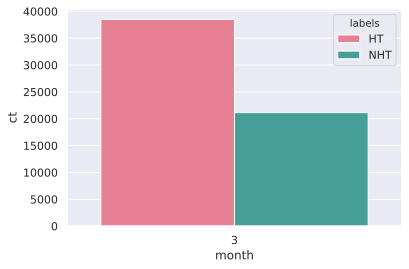

In [87]:
sns.barplot(x='month',y='ct',hue='labels', data=df_ct, palette='husl')

**We only have data for month of march and year 2018.That's wht we are not getting longitudnal data. We need to dig deeper perhaps weeks or days.**

In [0]:
df_bol['days']=df_bol['date'].dt.dayofweek

In [90]:
df_days=df_bol[['labels','days']]
df_days.head()

,labels,days
0,NHT,0
1,NHT,0
2,HT,0
3,NHT,0
4,NHT,0


In [94]:
df_days.days.unique()

array([0])

Again we have nothing here. So, we may not be able to get a longitudnal data. We may go by minutes.

In [0]:
df_bol['mins']=df_bol['date'].dt.minute

In [97]:
df_bol.mins.unique()

array([0])

We better move on with analysis.We will not get longitudnal pattern of data 

# 4)- Creating dataframe with Feature of Importance

In [0]:
df_foi=df_bol[['labels','visitor_recognition_type','country_by_ip_address','region_by_ip_address']]

In [99]:
df_foi.head()

,labels,visitor_recognition_type,country_by_ip_address,region_by_ip_address
0,NHT,ANONYMOUS,US,CA
1,NHT,ANONYMOUS,US,CA
2,HT,ANONYMOUS,IT,LI
3,NHT,ANONYMOUS,US,CA
4,NHT,ANONYMOUS,US,CA


### 4a)-Checking ANONYMOUS traffice role in data
As we have now more concise data classification so, we might want to check again 

**This "ANONYMOUS" class in visitor_recognition_type feature is interesting. It could be that bot searches are mostly ANONYMOUS. It is only an assumption. Let's see if data supports it**

In [0]:
c=df_foi

In [0]:
c=c[(c.visitor_recognition_type == 'ANONYMOUS')]
c=c.groupby(['labels','visitor_recognition_type']).size()

In [102]:
c

labels  visitor_recognition_type
HT      ANONYMOUS                   22426
NHT     ANONYMOUS                   21141
dtype: int64

**There is not much difference. So, my assumption that "ANONYMOUS" is related to Non-human traffic does not hold ground.**


In [103]:
df_foi.groupby(['labels', 'visitor_recognition_type']).count()

country_by_ip_address  region_by_ip_address
labels visitor_recognition_type                                             
HT     ANONYMOUS                                 22426                 22426
       LOGGEDIN                                   3482                  3482
       RECOGNIZED                                12589                 12589
NHT    ANONYMOUS                                 21141                 21141


one thing is for sure that all NHT is in ANONYMOUS category as seen above.

In [0]:
#df_foi.groupby(['labels', 'country_by_ip_address']).count()

# 4)- Saving file for future use


**Save file as pickle for binary classification**

In [0]:
df_foi.to_pickle('clickdata.pkl')